# Beamline Analyzer
### Uses G4Beamline "simple" files as input

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

In [147]:
_save_dir = 'plots/'

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

In [4]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# n_pions = 9511 * 30000
# config = 'config07_1'

# config08_1, BFIELD=0, cryo and LAr
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config08_1/merged_sim_arcs_beamline_simple_9881of30k_config08_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9881of30k_config08_1.root'
# n_pions = 9881 * 30000
# config = 'config08_1'

# config11_OLD_1 - OLD
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_4768of30k_config11_OLD_1.root'
# n_pions = 4768 * 30000
# config = 'config11_OLD_1'

# config11_1
f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9774of30k_config11_1.root'
n_pions = 9774 * 30000
config = 'config11_1'



In [5]:
det_list = ['DetT1', 'TOF1',  'DetT2', 'TOF2', 'Det7', 'JGGDet1']

In [6]:
file = uproot.open(f)
print('Detectors:', file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


Detectors: ['VirtualDetector;1', 'VirtualDetector/DetT1;1', 'VirtualDetector/DetT2;1', 'VirtualDetector/TOF1;1', 'VirtualDetector/TOF2;1', 'VirtualDetector/Det7;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 293220000
Number of spills: 1172.88
Number of hours: 19.548000000000002
Number of months: 0.027150000000000004


In [7]:
print('TTree variables:', file[f'VirtualDetector/JGGDet1'].keys())
# print('Number of entries in StartLine:', file[f'VirtualDetector/StartLine'].num_entries)
# print('Number of entries in DetT0:', file[f'VirtualDetector/DetT0'].num_entries)
print('Number of entries in DetT1:', file[f'VirtualDetector/DetT1'].num_entries)
print('Number of entries in DetT2:', file[f'VirtualDetector/DetT2'].num_entries)
print('Number of entries in Det7:', file[f'VirtualDetector/Det7'].num_entries)
print('Number of entries in JGGDet1:', file[f'VirtualDetector/JGGDet1'].num_entries)

TTree variables: ['x', 'y', 'z', 'Px', 'Py', 'Pz', 't', 'PDGid', 'EventID', 'TrackID', 'ParentID', 'Weight']
Number of entries in DetT1: 19059260
Number of entries in DetT2: 11547592
Number of entries in Det7: 5695594
Number of entries in JGGDet1: 58334033


In [8]:
def add_vars_to_df(df):
    '''
    Adds total momentum, as well as theta and phi, to the dataframe
    '''

    px = df['Px'].values
    py = df['Py'].values
    pz = df['Pz'].values

    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    df['P'] = p
    df['theta'] = theta
    df['phi'] = phi

    return df


In [9]:
branches = ['x', 'y', 'z', 't', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

dfs = {}

for det in det_list:
    dfs[det] = file[f'VirtualDetector/{det}'].arrays(branches, library='pd')
    dfs[det] = dfs[det].drop_duplicates(['EventID', 'TrackID'])
    dfs[det] = add_vars_to_df(dfs[det])


## Merge TTrees

Merge TTrees for Det7 (in front of the JGG), and JGGDet1 (inside the JGG) based on EventID and TrackID.

The goal is to keep particles that are present in both detectors. In other words, we only want particles that can cross Det7 and then reach ArCS, because there are the particles we can trigger on.

In [10]:
def merge_dataframes(det1='Det7', det2='JGGDet1'):
    '''
    Merges two dataframes based on EventID and TrackID

    Args:
        det1 (str): name of the first detector
        det2 (str): name of the second detector

    Returns:
        dataframe: the merged dataframe
    '''

    # Merge the dataframe for Det7 and JGGDet1 based on EventID and TrackID
    df = dfs[det1].merge(dfs[det2], on=['EventID', 'TrackID'], 
                           how='left', indicator=True,
                           suffixes=(f'_{det1}', f'_{det2}'))

    # Drop particles that are not in both detectors
    df = df[df['_merge'] == 'both']

    # Drop PDGid_Det7, as it's the same as PDGid_JGGDet1
    df = df.drop([f'PDGid_{det1}'], axis=1)

    # Rename PDGid_JGGDet1 to PDGid
    df = df.rename(columns={f'PDGid_{det2}': 'PDGid', })

    return df


In [11]:
# Merges the detectors in the desired detectors name

def merge_detectors(dfs, detector_names):

    print('Merging detectors:', detector_names)

    # Check if all detector names are present in the dfs
    missing_detectors = [det for det in detector_names if det not in dfs]
    if missing_detectors:
        raise ValueError(f"Detector names not found in dictionary: {', '.join(missing_detectors)}")
    
    if not detector_names:
        raise ValueError("detector_names list is empty")

    if len(detector_names) == 2:
        return merge_dataframes(detector_names[0], detector_names[1])

    # If more than 2 detectors to merge:
    
    # Initialize the merged df with the first detector
    df_merged = dfs[detector_names[0]]
    
    # Loop through the remaining detectors and merge
    for i in range(1, len(detector_names)):
        print(f"Merging number: {i}")
        
        current_det = detector_names[i]
        prev_det = detector_names[i - 1]
        
        # Merge
        df_merged = df_merged.merge(dfs[current_det], on=['EventID', 'TrackID', 'PDGid'],
                                    how='left', indicator=f'_merge_{i}',
                                    suffixes=('_' + prev_det, '_' + current_det))
        
        # Keep only rows that are present in both detectors
        # df_merged = df_merged[df_merged[f'_merge_{i}'] == 'both']

        # Drop redundant columns
        # columns_to_drop = [col for col in df_merged.columns if col.startswith('PDGid_')]
        # if columns_to_drop:
        #     df_merged = df_merged.drop(columns=columns_to_drop)
        
        # Check for columns without an underscore in the name, excluding 'EventID', 'TrackID', and 'PDGid_' columns
        columns_without_underscore = [col for col in df_merged.columns if (
            '_' not in col and col not in ['EventID', 'TrackID', 'PDGid'])]
        
        # Append the current detector's suffix to these columns
        rename_dict = {col: col + '_' + current_det for col in columns_without_underscore}
        df_merged = df_merged.rename(columns=rename_dict)

        #print(df_merged.head())

    # df_merged = df_merged.rename(columns={f'PDGid_{detector_names[len(detector_names)-1]}':'PDGid'})
    
    return df_merged


In [12]:
df = merge_detectors(dfs, det_list)


Merging detectors: ['DetT1', 'TOF1', 'DetT2', 'TOF2', 'Det7', 'JGGDet1']
before 18848181
after 18848181
before 18848181
after 18848181
before 18848181
after 18848181
before 18848181
after 18848181
before 18848181
after 18848181


In [13]:
# ['DetT1', 'DetT2', 'Det7', 'JGGDet1']

bools = ((df['_merge_1'] == 'both').values) \
        & ((df['_merge_2'] == 'both').values) \
        & ((df['_merge_3'] == 'both').values) \
        & ((df['_merge_4'] == 'both').values)

print(len(bools), len(df))
df['triggered'] = bools

# 687498

np.sum(df['triggered'].values)

18848181 18848181


1586978

In [127]:
df.query('PDGid==11').head()

,x_DetT1,y_DetT1,z_DetT1,t_DetT1,Px_DetT1,Py_DetT1,Pz_DetT1,PDGid,EventID,TrackID,...,z_JGGDet1,t_JGGDet1,Px_JGGDet1,Py_JGGDet1,Pz_JGGDet1,P_JGGDet1,theta_JGGDet1,phi_JGGDet1,_merge_5,triggered
144,-26.315123,51.942295,11987.500000,41.654343,-6.482400,6.640134,1542.422241,11.0,29971112.0,130455.0,...,38904.808594,131.446915,64.870499,-11.2807,560.154053,564.01062,6.704141,-9.864841,both,False
147,-35.341167,-62.500000,12010.131836,41.739899,-0.334797,0.466371,0.172452,11.0,29971112.0,135994.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False
209,-28.161491,-27.940771,11987.500000,45.454960,-0.794932,0.500880,1.844283,11.0,29972088.0,48510.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False
222,31.552181,44.444233,11987.500000,41.660618,-0.962298,-1.154162,91.896675,11.0,29972500.0,39580.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False
232,-16.911936,31.211632,11987.500000,41.653992,-4.198985,8.494303,3287.104004,11.0,29972664.0,52777.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False


In [15]:
df_trig = df.query('triggered == True')

In [16]:
particles = df_trig.groupby('PDGid').groups.keys()
particles

dict_keys([-2212.0, -321.0, -211.0, -13.0, -11.0, 11.0, 13.0, 22.0, 211.0, 321.0, 2212.0])

In [132]:
# Calculates the detection rate per minute of electrons and positrons given a df, detecto name, n. of pions
#and the spill rate

def particle_rates(df, det, n_pions, pion_rate=2.5e5, p_range=None, do_print=False):

    if p_range is not None:
        if f'P_{det}' in df.columns:
            df = df.query(f'P_{det} > {p_range[0]} and P_{det} < {p_range[1]}')
        else:
            df = df.query(f'P > {p_range[0]} and P < {p_range[1]}')
            

    protons = df[abs(df['PDGid']) == 2212]
    kaons = df[abs(df['PDGid']) == 321]
    pions = df[abs(df['PDGid']) == 211]
    muons = df[abs(df['PDGid']) == 13]
    electrons = df[abs(df['PDGid']) == 11]

    tot = len(protons) + len(kaons) + len(pions) + len(muons) + len(electrons)
    
    # Calculate the number of pion spills
    n_spills = n_pions / pion_rate

    if do_print:
        print(f'Detector: {det}')
    
        print(f'Protons per spill: {len(protons) / n_spills}')
        print(f'Kaons per spill: {len(kaons) / n_spills}')
        print(f'Pions per spill: {len(pions) / n_spills}')
        print(f'Muons per spill: {len(muons) / n_spills}')
        print(f'Electrons per spill: {len(electrons) / n_spills}')
        print(f'Total particles per spill: {tot / n_spills}')

    out_list = [
        len(protons) / n_spills,
        len(kaons) / n_spills,
        len(pions) / n_spills,
        len(muons) / n_spills,
        len(electrons) / n_spills
    ]
    
    return tot / n_spills, out_list


In [77]:
from collections import OrderedDict
# tot_hits = OrderedDict()
# triggering_hits = None

npars = {}
npars_trig = {}

p_range = [0, 2500]

for det in det_list:
    _, npars_trig = particle_rates(df_trig, det, n_pions, p_range=p_range)
    print('\n')
    tot, l = particle_rates(dfs[det], det, n_pions, p_range=p_range)
    tot_hits[det] = tot
    npars[det] = l
    print('\n ************** \n')

Detector: DetT1
Protons per spill: 0.6795239069640542
Kaons per spill: 0.017904644976468178
Pions per spill: 2.2764477184366685
Muons per spill: 0.5354341450105722
Electrons per spill: 11.864811404406247
Total particles per spill: 15.37412181979401


Detector: DetT1
Protons per spill: 33.984721369620075
Kaons per spill: 2.6132255644226174
Pions per spill: 75.90375827024077
Muons per spill: 18.64981924834595
Electrons per spill: 896.3167587476979
Total particles per spill: 1027.4682832003273

 ************** 

Detector: TOF1
Protons per spill: 0.6795239069640542
Kaons per spill: 0.017904644976468178
Pions per spill: 2.2764477184366685
Muons per spill: 0.5354341450105722
Electrons per spill: 11.86907441511493
Total particles per spill: 15.378384830502693


Detector: TOF1
Protons per spill: 51.58413477934656
Kaons per spill: 6.451640406520701
Pions per spill: 149.91303458154286
Muons per spill: 26.417024759566193
Electrons per spill: 1878.1836163972441
Total particles per spill: 2112.5494

In [78]:
npars_trig

[0.59085328422345,
 0.017904644976468178,
 2.078644021553782,
 0.5763590478139281,
 14.4089761953482]

In [79]:
npars_toplot = {key: npars[key] for key in ['DetT1', 'TOF1', 'DetT2', 'TOF2'] if key in npars}
npars_toplot['Triggerable'] = npars_trig

In [80]:
colors

[(0.09411764705882353, 0.12941176470588237, 0.3607843137254902),
 'gray',
 (0.42745098039215684, 0.4, 0.5725490196078431),
 (0.34509803921568627, 0.5098039215686274, 0.6862745098039216),
 (0.5058823529411764, 0.7098039215686275, 0.796078431372549),
 (0.7725490196078432, 0.8666666666666667, 0.803921568627451)]

In [135]:

p_range = [0, 2500]
_, npars_trig = particle_rates(df_trig, det, n_pions, p_range=p_range)
_, npars = particle_rates(dfs[det], det, n_pions, p_range=p_range)

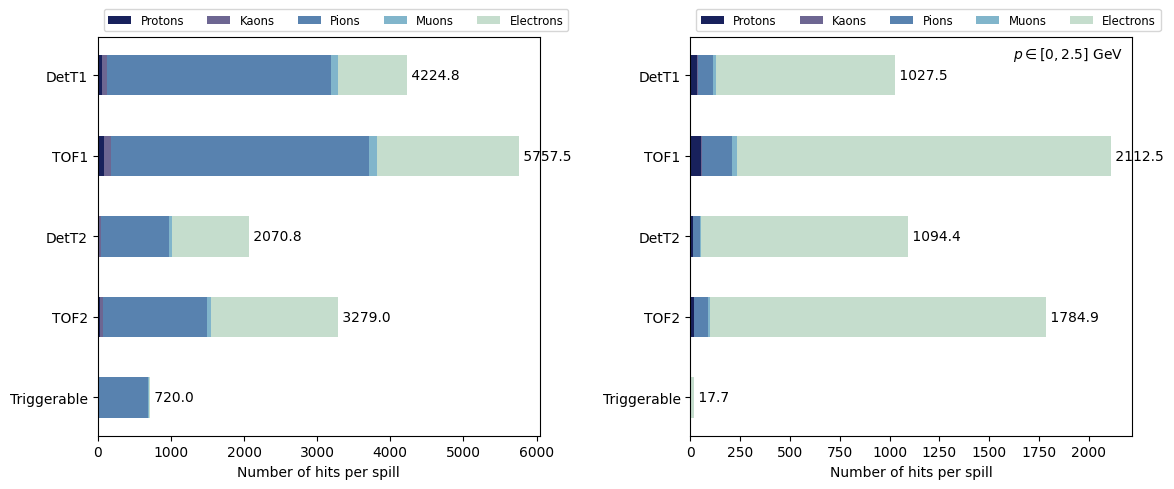

In [168]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

for i, ax in enumerate(axes):

    if i == 0: p_range = None
    if i == 1: p_range = [0, 2500]

    npars_trig
    npars = {}
    for det in det_list:
        _, npars_trig = particle_rates(df_trig, det, n_pions, p_range=p_range)
        _, npars_ = particle_rates(dfs[det], det, n_pions, p_range=p_range)
        npars[det] = npars_

    npars_toplot = {key: npars[key] for key in ['DetT1', 'TOF1', 'DetT2', 'TOF2'] if key in npars}
    npars_toplot['Triggerable'] = npars_trig

    ax.invert_yaxis()
    
    labels = list(npars_toplot.keys())
    data = np.array(list(npars_toplot.values()))
    data_cum = data.cumsum(axis=1)
    
    category_colors = plt.colormaps['RdYlGn'](
            np.linspace(0.15, 0.85, data.shape[1]))
    
    category_names = ['Protons', 'Kaons',
                      'Pions', 'Muons', 'Electrons']
    
    colors_ = [
        (24/ 255, 33/ 255, 92/ 255),
        (109/ 255, 102/ 255, 146/ 255),
        (88/ 255, 130/ 255, 175/ 255),
        (129/ 255, 181/ 255, 203/ 255),
        (197/ 255, 221/ 255, 205/ 255),
    ]
    
    for i, (colname, color) in enumerate(zip(category_names, colors_)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
        # r, g, b, _ = color
        # text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        # ax.bar_label(rects, label_type='center')
    
    for i, rect in enumerate(rects):
        total = data_cum[i, -1]
        ax.text(total, rect.get_y() + rect.get_height() / 2, f' {total:.1f}', ha='left', va='center')

    if p_range is not None:
        ax.text(0.98, 0.98, r'$p \in [0, 2.5]$ GeV', 
                 horizontalalignment='right', 
                 verticalalignment='top', 
                 transform=plt.gca().transAxes)
    
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    ax.set_xlabel('Number of hits per spill')
    # ax.set_ylabel('Beamline Detector')

plt.tight_layout()
plt.savefig(_save_dir + f'composition_{config}.pdf')
plt.show()

In [132]:
# df.query('PDGid==11 and P_Det7 < 100 and theta_Det7 < 10')

In [133]:
# print(len(df.query('PDGid==11 and ')))
# print(len(df.query('PDGid==-11')))

In [148]:
def get_values_labels(df, det='JGGDet1', variable='p', p_cut=80):
    '''
    Returns values to plot with their labels

    Args:
        det (str): the detector to plot
        variable (str): the variable to plot
        p_cut (int): momentum cut
    '''

    # Apply a momentum cut
    df_ = df.query(f'P_{det} > {p_cut}')

    # if det == 'Det7':
    #     df_ = df_.query(f'theta_{det} < 1')

    pdg = df_['PDGid'].values

    if variable == 'p':
        var = df_[f'P_{det}'].values
    elif variable == 'theta':
        var = df_[f'theta_{det}'].values
    elif variable == 'phi':
        var = df_[f'phi_{det}'].values
    elif variable == 't':
        var = df_[f't_{det}'].values
        
    kaons = var[np.abs(pdg)==321]
    positrons = var[pdg==-11]
    electrons = var[pdg==+11]
    muons = var[np.abs(pdg)==13]
    protons = var[np.abs(pdg)==2212]
    pions = var[np.abs(pdg)==211]
    others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    gamma = var[np.abs(pdg)==22]
    
    values = [
        # others,
        # gamma,
        kaons,
        positrons,
        electrons,
        muons,
        protons,
        pions,
    ]

    tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
    # tot += len(others)
    # tot += len(gamma)
    
    labels = [
        # 'others' + f', ({len(others) / tot * 100:.1f}%)',
        # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
        r'$K^\pm$' + f', ({len(kaons):.2e}, {len(kaons) / tot * 100:.1f}%)',
        r'$e^+$' + f', ({len(positrons):.2e}, {len(positrons) / tot * 100:.1f}%)',
        r'$e^-$' + f', ({len(electrons):.2e}, {len(electrons) / tot * 100:.1f}%)',
        r'$\mu^\pm$' + f', ({len(muons):.2e}, {len(muons) / tot * 100:.1f}%)',
        r'$p^\pm$' + f', ({len(protons):.2e}, {len(protons) / tot * 100:.1f}%)',
        r'$\pi^\pm$' + f', ({len(pions):.2e}, {len(pions) / tot * 100:.1f}%)'
    ]

    return values, labels

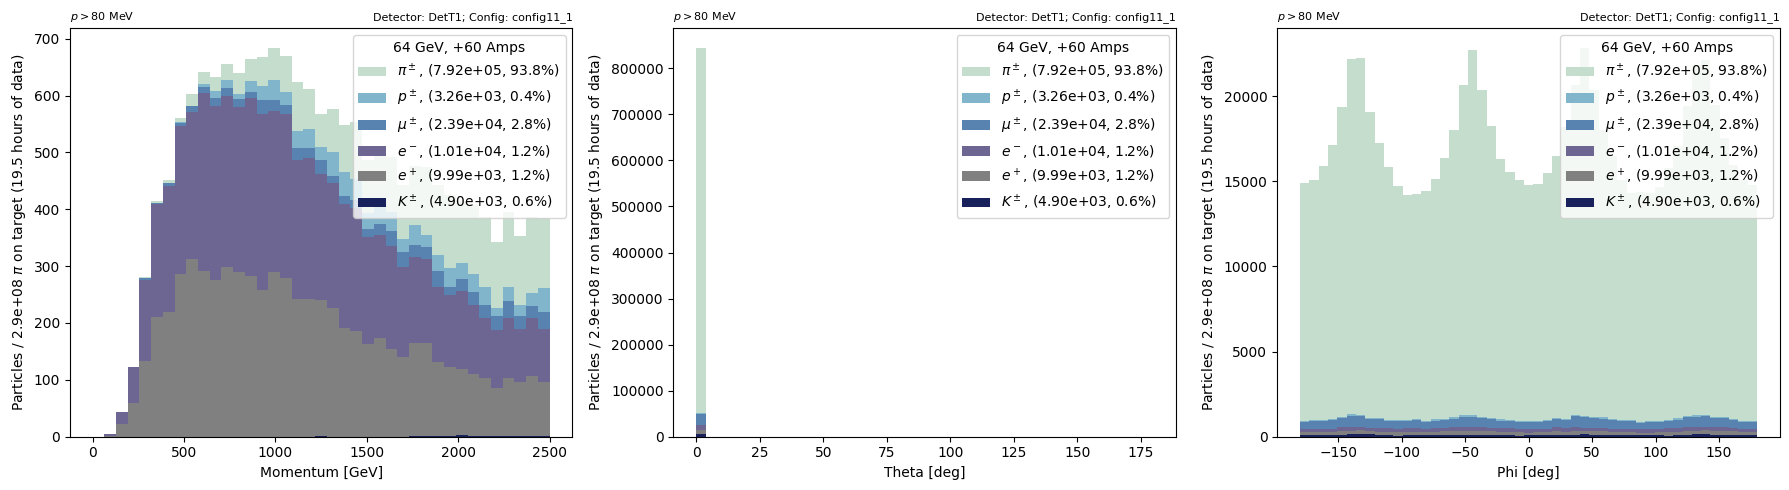

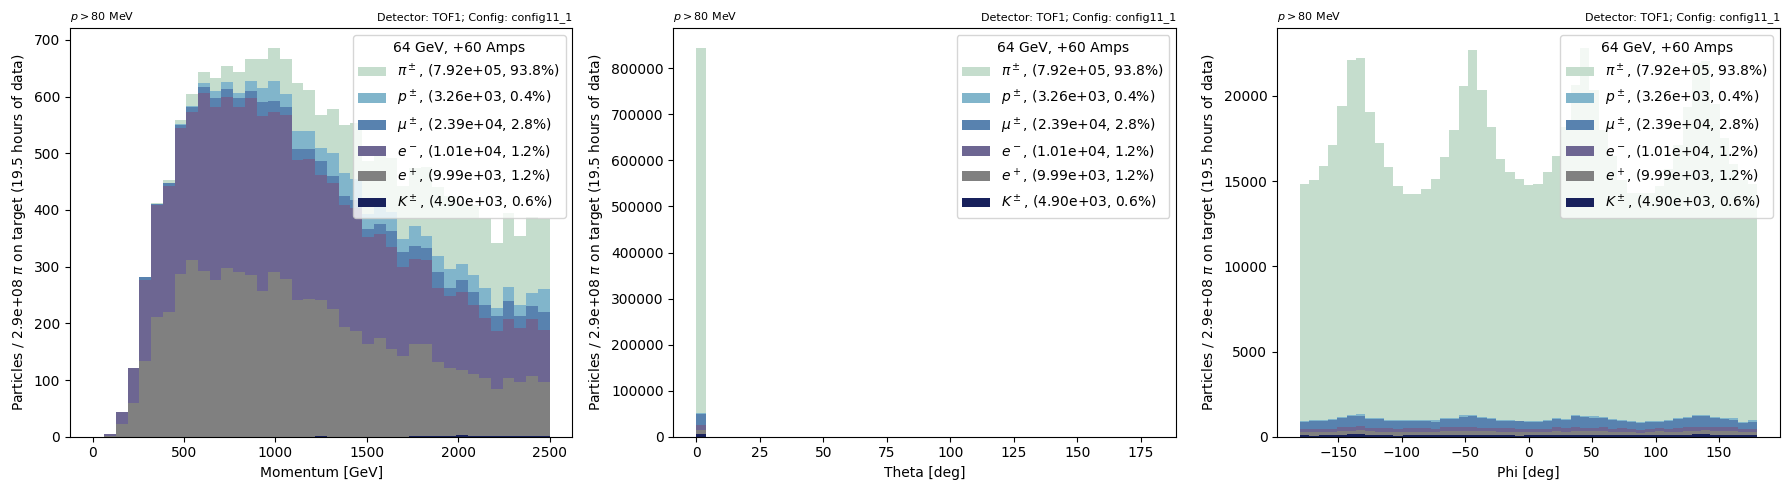

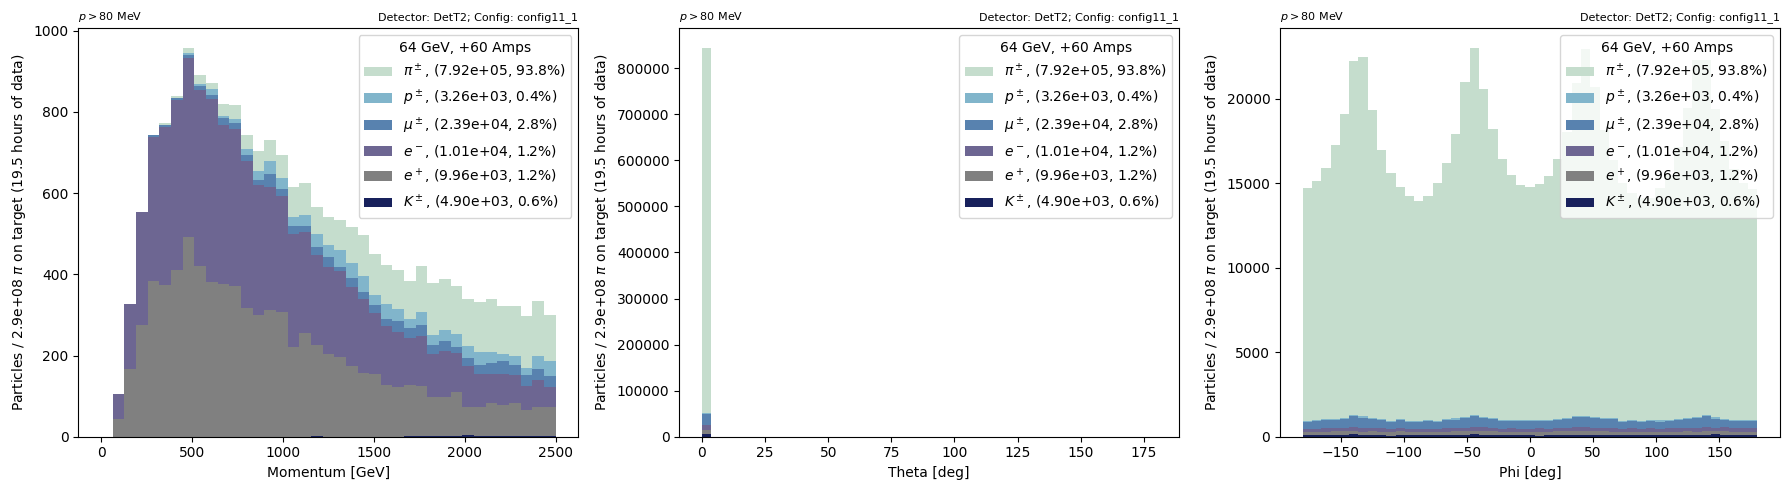

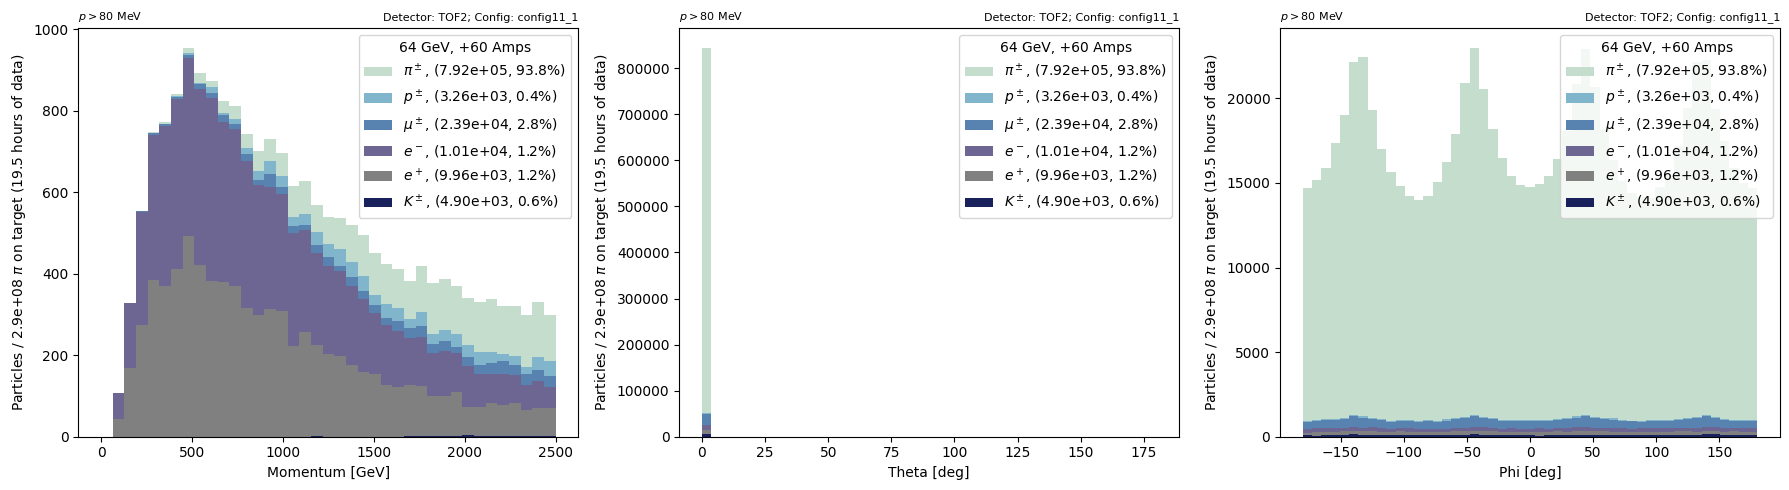

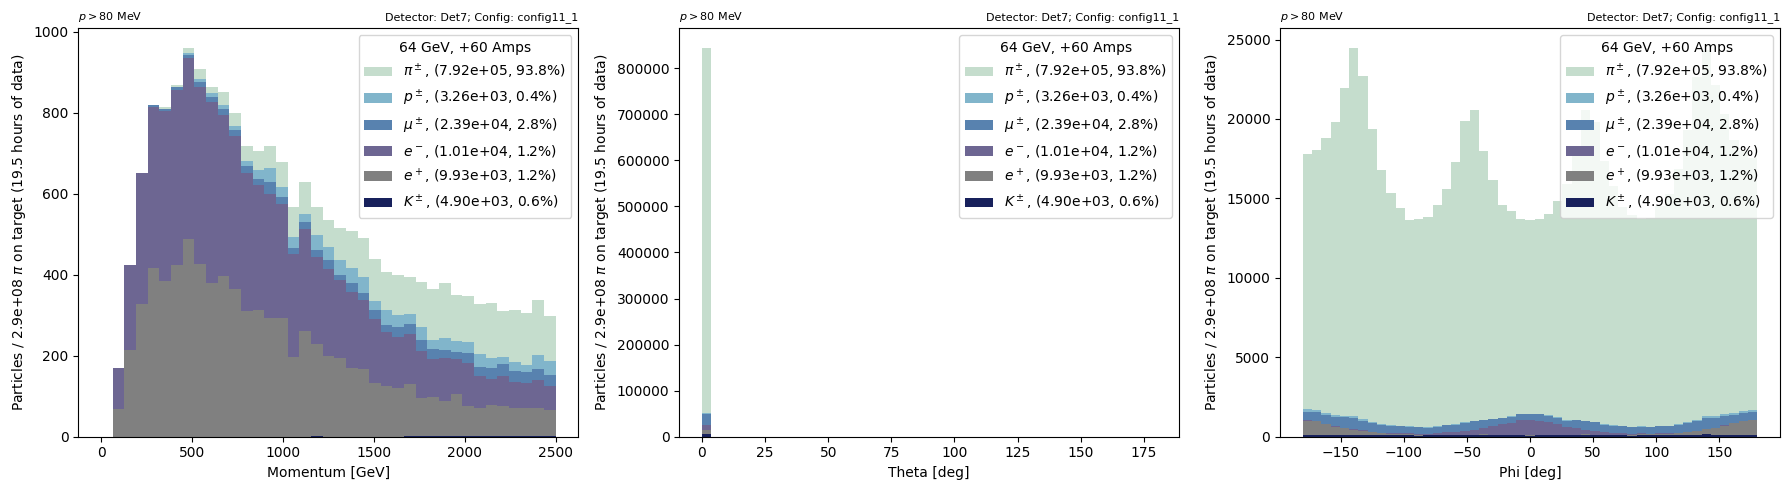

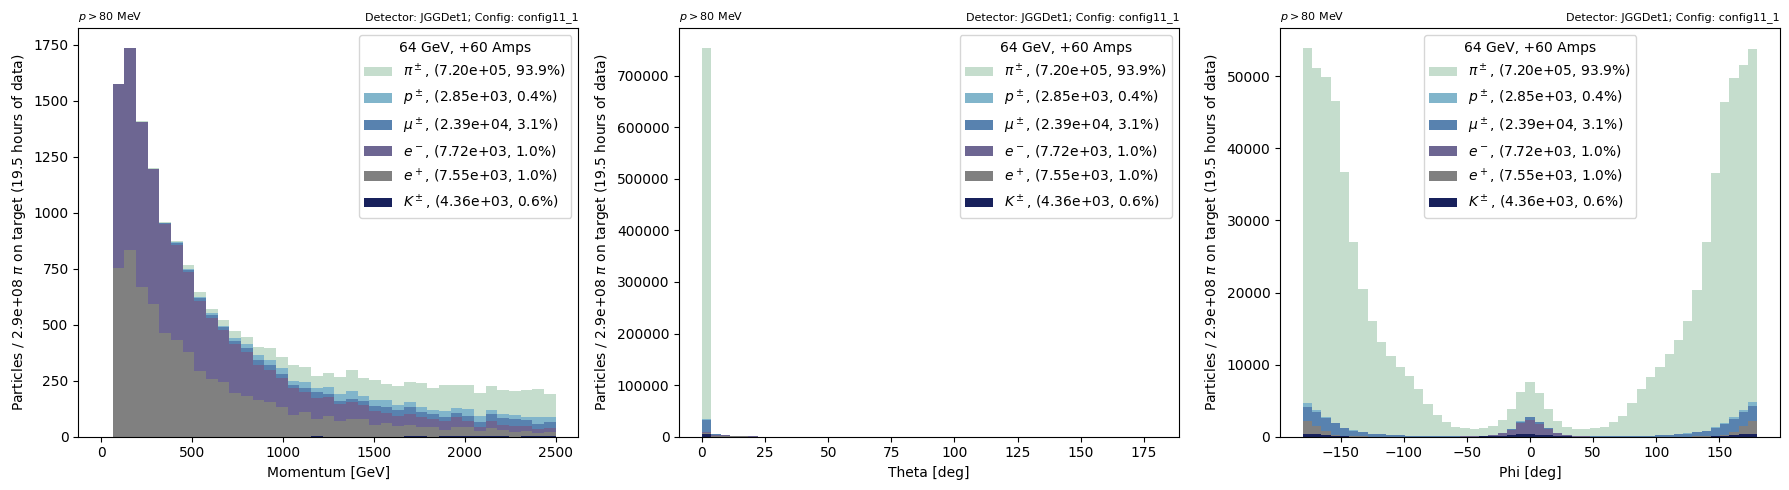

In [151]:
for det in det_list: #['DetT1', 'DetT2', 'Det7', 'JGGDet1']:
# for det in ['Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 40),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 80

        values, labels = get_values_labels(df_trig, det, variable, p_cut)
    
        bins = x_bins[variable]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e}' + r' $\pi$' + f' on target ({n_hours:.1f} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_df_{config}_det{det}.pdf')
    plt.show()


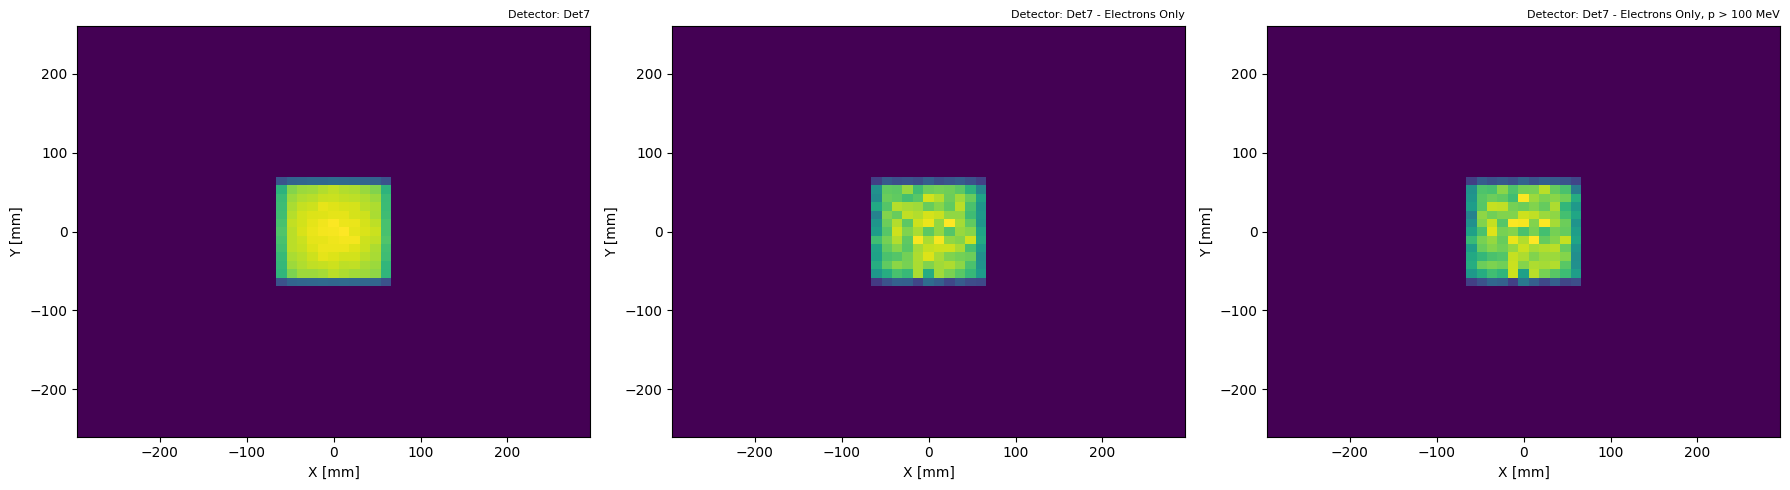

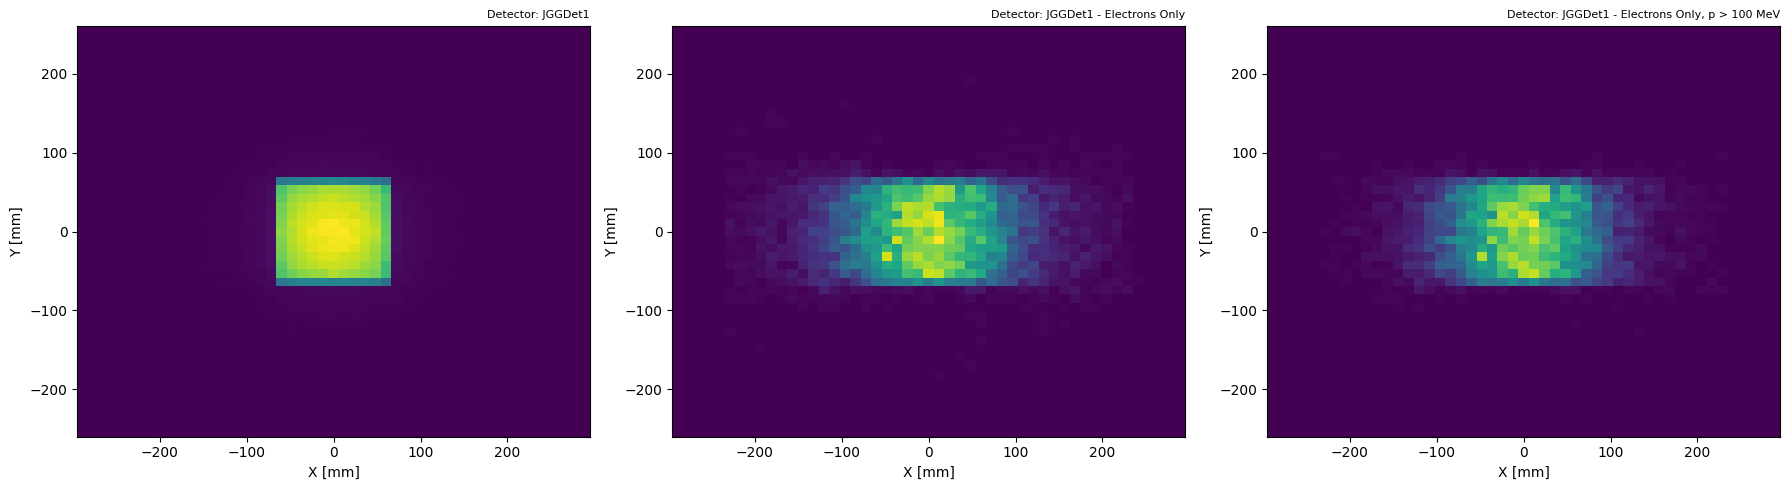

In [137]:
for det in ['Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    if det == 'Det4':
        xbins = np.linspace(-64-1195.0827-10, 64-1195.0827+10, 50)
        ybins = np.linspace(-62.5-20.4724-10, 62.5-20.4724+10, 50)
    ax[0].hist2d(df_trig[f'x_{det}'].values, df_trig[f'y_{det}'].values, bins=[xbins, ybins])
    ax[0].set_xlabel('X [mm]')
    ax[0].set_ylabel('Y [mm]')
    ax[0].set_title(f'Detector: {det}', loc='right', fontsize=8)

    # mask_e = np.abs(pdg) == 11
    ax[1].hist2d(df_trig.query('abs(PDGid)==11')[f'x_{det}'], df_trig.query('abs(PDGid)==11')[f'y_{det}'], bins=[xbins, ybins])
    ax[1].set_xlabel('X [mm]')
    ax[1].set_ylabel('Y [mm]')
    ax[1].set_title(f'Detector: {det} - Electrons Only', loc='right', fontsize=8)

    # mask_p = particle.p > 200
    ax[2].hist2d(df_trig.query('abs(PDGid)==11 and Pz_JGGDet1 > 100')[f'x_{det}'], df_trig.query('abs(PDGid)==11 and Pz_JGGDet1 > 100')[f'y_{det}'], bins=[xbins, ybins])
    ax[2].set_xlabel('X [mm]')
    ax[2].set_ylabel('Y [mm]')
    ax[2].set_title(f'Detector: {det} - Electrons Only, p > 100 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_df_pos_{config}_det{det}.pdf')
    plt.show()


## Particle Timings

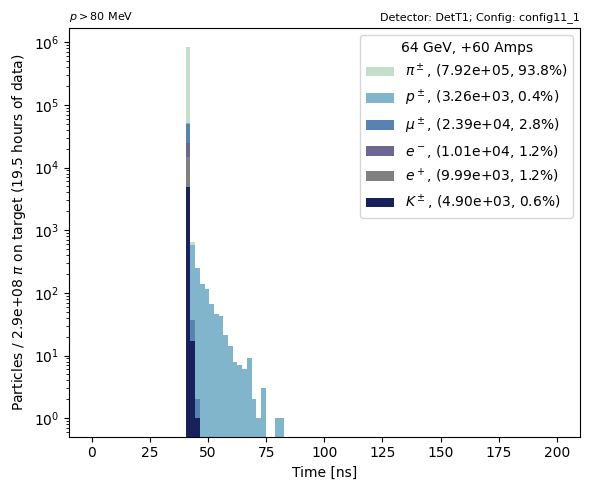

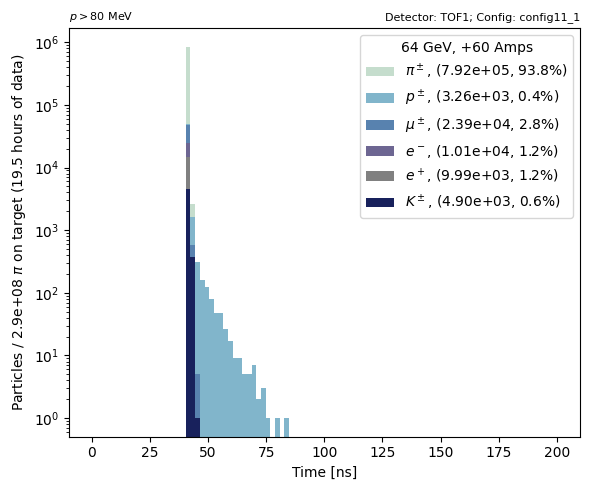

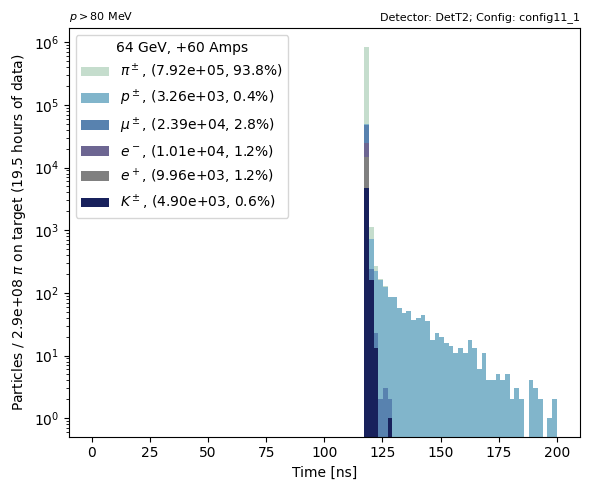

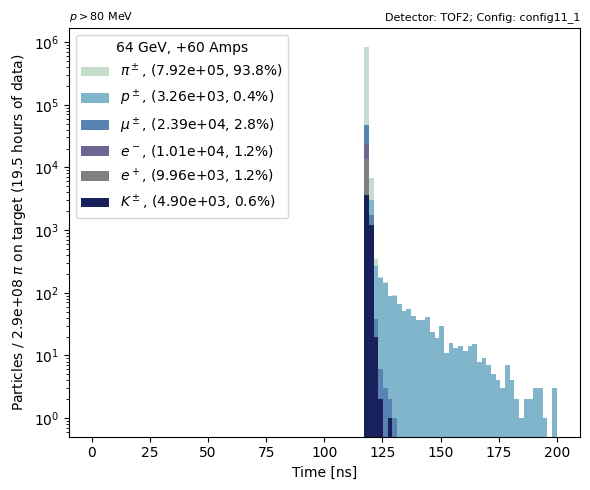

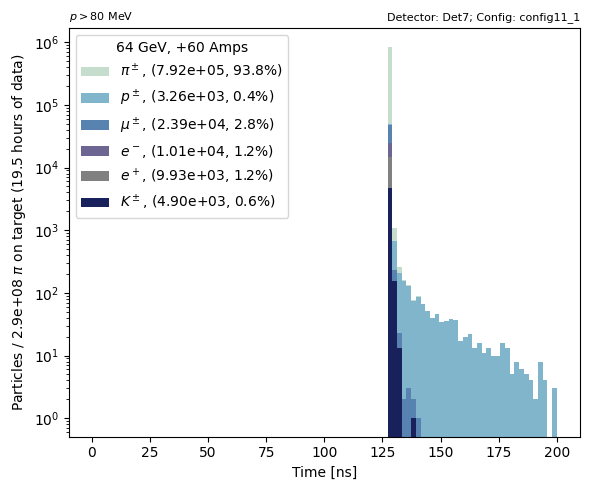

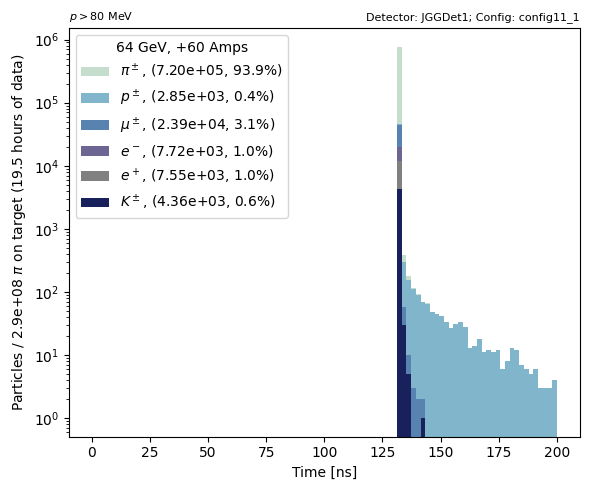

In [153]:
for det in det_list:

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    p_cut = 80

    values, labels = get_values_labels(df_trig, det, variable='t', p_cut=p_cut)

    bins = np.linspace(0, 200, 100)
    
    ax.hist(values, bins=bins, color=colors, label=labels, stacked=True)
    
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)

    ax.set_xlabel('Time [ns]')
    ax.set_ylabel(f'Particles / {n_pions:.1e}' + r' $\pi$ ' + f'on target ({n_hours:.1f} hours of data)' )
    ax.set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax.set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)

    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_time_df_{config}_det{det}.pdf')
    plt.show()


In [154]:
momenta, _ = get_values_labels(df_trig, 'TOF1', variable='p', p_cut=0)

values_1, labels_ = get_values_labels(df_trig, 'TOF1', variable='t', p_cut=0)
values_2, _ = get_values_labels(df_trig, 'TOF2', variable='t', p_cut=0)

tof = [t_2 - t_1 for t_1, t_2 in zip(values_1, values_2)]
labels = [l.split(',')[0] for l in labels_]
labels

['$K^\\pm$', '$e^+$', '$e^-$', '$\\mu^\\pm$', '$p^\\pm$', '$\\pi^\\pm$']

$K^\pm$ 4.180308300934452 3.6934724780028643
$e^+$ 8.520053202373644 8.520053202373644
$e^-$ 8.614692040106403 8.614692040106403
$\mu^\pm$ 20.40959006889025 20.194734329172633
$p^\pm$ 2.7794829820612508 0.9949866994065888
$\pi^\pm$ 675.5379919514357 674.2556783302639


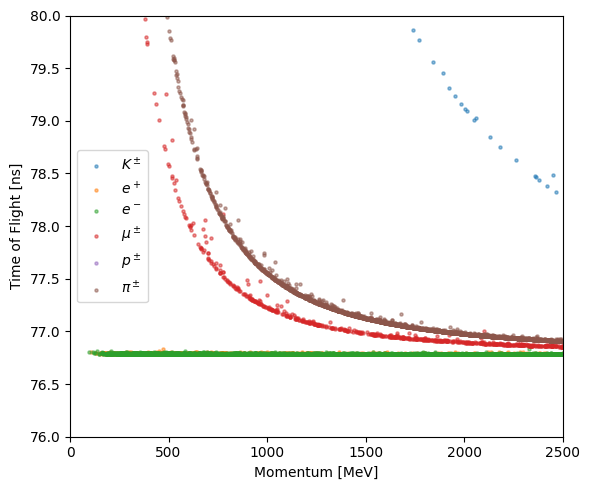

In [166]:
index = 4

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

xbins = np.linspace(0, 2500, 50)
ybins = np.linspace(0, 200, 50)

# ax.hist2d(momenta[index], tof[index], bins=[xbins, ybins])
# ax.scatter(momenta[4], tof[4], alpha=0.1)
# ax.scatter(momenta[1], tof[1], alpha=0.1)

for i, label in enumerate(labels):
    ax.scatter(momenta[i], tof[i], alpha=0.5, label=label, s=5)
    print(label, len(tof[i])/n_spills, len(tof[i][tof[i]<77])/n_spills)

ax.set_xlabel('Momentum [MeV]')
ax.set_ylabel('Time of Flight [ns]')
# ax.set_title(f'Particles: {labels[index]}', loc='right', fontsize=8)

# ax.set_xlabel('Time')
# ax.set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
# ax.set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
# ax.set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)

# ax.set_yscale('log')

ax.legend()

ax.set_xlim([0, 2500])
# ax.set_ylim([70, 140])
ax.set_ylim([76, 80])

plt.tight_layout()
plt.savefig(_save_dir + f'spectra_g4blsimple_tof_df_{config}.png')
plt.show()
